### problem-3: try to reproduce where I have too low exchange current density

In [132]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

import csv, random, os
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl; 
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
########################     Global settings!!!
rows_per_file = 3;  Scan_end_end = 150;
purpose_i = "OneCyc_Problem_2"
Scan_start =1;  Scan_end=1;
purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
On_HPC = False 
Runshort = True                    # a long run or a quick test

In [134]:
On_HPC = False
if On_HPC:                          # Run on HPC
    Path_Data_pre = "InputData/" 
    BasicPath=os.getcwd() 
    #Para_file = Path_Data +  para_csv
else:
    import sys  
    str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
    str_path_1 = os.path.abspath(
        os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
    sys.path.append(str_path_1) 
    Path_Data_pre = os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
    BasicPath =  os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/HPC_Paper")
    #Para_file = BasicPath+'/Get_Random_sets/'+para_csv

In [135]:
from Fun_P2 import *

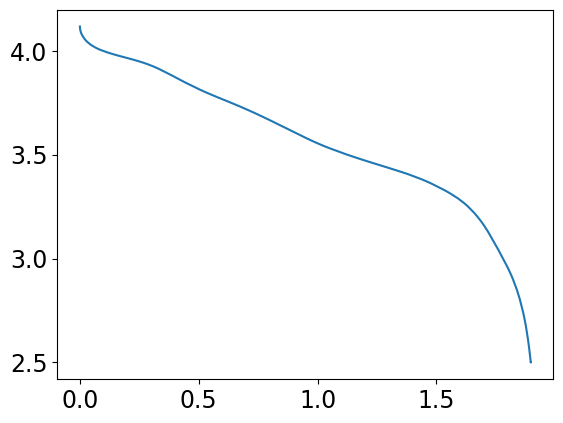

In [136]:
# try to plot experiment data
import pandas as pd
Path_Data  = Path_Data_pre+"Example_data/"+"example_0p5C_discharge.csv"
my_data = pd.read_csv( Path_Data)

t_exp   = (my_data["Time (s)"] - my_data["Time (s)"][0])/3600
cap_dis = (my_data["Charge (mA.h)"] - my_data["Charge (mA.h)"][0])/1e3
V_exp = my_data["Voltage (V)"]
t_exp = np.array(t_exp).tolist()
V_exp = np.array(V_exp).tolist()
plt.plot(t_exp,V_exp)
XY_Exp =[t_exp,V_exp]
#my_data 

# Get input file or just input

In [137]:
# Functions, will put into the .py file later
def save_rows_to_csv(file_path, rows, header):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)  # Write parameter names as the header row
        writer.writerows(rows)
def generate_combinations(Bounds, Num_tot):
    lower_bounds = []
    upper_bounds = []
    for bound in Bounds:
        lower_bounds.append(bound[0])
        upper_bounds.append(bound[1])
    combinations = []
    for _ in range(Num_tot):
        combination = []
        for lower, upper in zip(lower_bounds, upper_bounds):
            value = random.uniform(lower, upper)
            combination.append(value)
        combinations.append(combination)
    return combinations

def save_combinations_to_csv(combinations, parameter_names, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(parameter_names)  # Write parameter names as the first row
        for combination in combinations:
            writer.writerow(combination)
# Pack input needs to be a list
def Get_Scan_files(
        BasicPath,Target_name,model_options,
        parameter_names,para_short_name,
        Pack,
        rows_per_file,Bundle):
    
    import itertools
    para_dict_Same = {
        "Cycles within RPT":1,
        "RPT temperature":25,
        "Mesh list":[5,5,5,60,20],  
        "Para_Set": "OKane2023",
        "Model option":model_options,
        "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
        "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
        "Ratio of Li-ion concentration change in " 
        "electrolyte consider solvent consumption":1.0,
        'EC initial concentration in electrolyte [mol.m-3]':4541.0,
        'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
        "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
        "Initial inner SEI thickness [m]": 1.23625e-08,
        "Initial outer SEI thickness [m]": 1.23625e-08,
        "Negative electrode porosity": 0.222393,
        }
    unchange_key2 = list(para_dict_Same.keys())
    unchange_val2 = list(para_dict_Same.values())
    short_pack = [lst for lst in Pack if len(lst) > 1]
    selected_indices = [i for i, lst in enumerate(Pack) if len(lst) > 1]
    shortList_para_short_name = [para_short_name[i] for i in selected_indices]
    shortList_para_short_name.insert(0,"No")
    really_change_val =  [
        list(comb) for comb in itertools.product(*short_pack)]

    change_val =  [
        list(comb) for comb in itertools.product(*Pack)]
    combinations = [[i+1,*elem, *unchange_val2] for i,elem in enumerate(change_val)]
    comb_short   = [[i+1,*elem] for i,elem in enumerate(really_change_val)]
    parameter_names = [*parameter_names,*unchange_key2]
    print("Total cases number is",len(combinations))
    if Bundle:
        # Specify the total number of cases
        total_cases = len(combinations)
        # Specify the number of rows per CSV file, rows_per_file
        # Calculate the number of files needed
        num_files = (total_cases - 1) // rows_per_file + 1
        # Create the target folder
        folder_path = os.path.join(BasicPath, "Get_Random_sets", Target_name)
        os.makedirs(folder_path, exist_ok=True)
        # Write data to each CSV file
        for i in range(num_files):
            file_name = f"Bundle_{i+1}.csv"
            file_path = os.path.join(folder_path, file_name)
            start_row = i * rows_per_file
            end_row = min(start_row + rows_per_file, total_cases)
            rows = combinations[start_row:end_row]
            save_rows_to_csv(file_path, rows, parameter_names)
        filename = BasicPath+f"/Get_Random_sets/{Target_name}/"+f'{Target_name}.csv'
        filename_short = BasicPath+f"/Get_Random_sets/{Target_name}/"+f'{Target_name}_s.csv'
        save_combinations_to_csv(combinations, parameter_names, filename)
        save_combinations_to_csv(comb_short, shortList_para_short_name, filename_short)
        print(f"Combinations saved to '{Target_name}.csv' file.") 
        print(f"CSV files created in folder '{Target_name}'.")
    else:
        filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
        save_combinations_to_csv(combinations, parameter_names, filename)
        print(f"Combinations saved to '{Target_name}.csv' file.") 
    return len(combinations)
# pack input can not either be a list or a tuple
def get_list_from_tuple(d, num):
    if d[1] > d[0]:
        if d[1] > 100 * d[0]:
            result_list = (np.exp(np.linspace(np.log(d[0]), np.log(d[1]), num=num))).tolist()
        else:
            result_list = (np.linspace(d[0], d[1], num=num)).tolist()
    else:
        result_list = []
    return result_list
def Get_Scan_Orth_Latin(
        BasicPath,Target_name,model_options,
        parameter_names,para_short_name,
        Pack, num,
        rows_per_file,Bundle):
    
    import itertools; from pyDOE import lhs
    para_dict_Same = {
        "Cycles within RPT":1,
        "RPT temperature":25,
        "Mesh list":[5,5,5,60,20],  
        "Para_Set": "OKane2023",
        "Model option":model_options,
        "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
        "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
        "Ratio of Li-ion concentration change in " 
        "electrolyte consider solvent consumption":1.0,
        'EC initial concentration in electrolyte [mol.m-3]':4541.0,
        'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
        "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
        "Initial inner SEI thickness [m]": 1.23625e-08,
        "Initial outer SEI thickness [m]": 1.23625e-08,
        "Negative electrode porosity": 0.222393,
        }
    unchange_key2 = list(para_dict_Same.keys())
    unchange_val2 = list(para_dict_Same.values())
    
    Pack_tuple = []; Pack_tuple_index = []
    Pack_list = [];  Pack_list_index  = []
    for i,item in enumerate(Pack):
        if isinstance(item, tuple):
            Pack_tuple.append(item)
            Pack_tuple_index.append(i)
        elif isinstance(item, list):
            Pack_list.append(item)
            Pack_list_index.append(i)
    com_tuple = []; comb_tu_list =[]
    if len(Pack_tuple) > 1:
        for tuple_i in Pack_tuple:
            com_tuple.append( get_list_from_tuple(tuple_i, num) )
        # apply Latin Hypercube:
        #print(com_tuple)
        samples = lhs(len(com_tuple), samples=num)
        for sample in samples:
            combination = []
            for i, candidate_list in enumerate(com_tuple):
                index = int(sample[i] * num)
                combination.append(candidate_list[index])
            comb_tu_list.append(combination)
    else:
        print("error! Pack_tuple must has 2 elements")
    # apply product sampling:
    comb_li_list = [list(comb) for comb in itertools.product(*Pack_list)]
    #print(comb_tu_list)
    #print(comb_li_list)
    Big_Comb = []
    for comb_tu in comb_tu_list:
        for comb_li in comb_li_list:
            big_comb = [0] * (len(comb_tu)+len(comb_li))
            for comb_tu_i,index in zip(comb_tu,Pack_tuple_index):
                big_comb[index] = comb_tu_i
            for comb_li_i,index in zip(comb_li,Pack_list_index):
                big_comb[index] = comb_li_i
            Big_Comb.append(big_comb)
    #print(Big_Comb)
    Big_Comb
    combinations = [[i+1,*elem, *unchange_val2] for i,elem in enumerate(Big_Comb)]

    parameter_names = [*parameter_names,*unchange_key2]
    print("Total cases number is",len(combinations))
    if Bundle:
        # Specify the total number of cases
        total_cases = len(combinations)
        # Specify the number of rows per CSV file, rows_per_file
        # Calculate the number of files needed
        num_files = (total_cases - 1) // rows_per_file + 1
        # Create the target folder
        folder_path = os.path.join(BasicPath, "Get_Random_sets", Target_name)
        os.makedirs(folder_path, exist_ok=True)
        # Write data to each CSV file
        for i in range(num_files):
            file_name = f"Bundle_{i+1}.csv"
            file_path = os.path.join(folder_path, file_name)
            start_row = i * rows_per_file
            end_row = min(start_row + rows_per_file, total_cases)
            rows = combinations[start_row:end_row]
            save_rows_to_csv(file_path, rows, parameter_names)
        filename = BasicPath+f"/Get_Random_sets/{Target_name}/"+f'{Target_name}.csv'
        filename_short = BasicPath+f"/Get_Random_sets/{Target_name}/"+f'{Target_name}_s.csv'
        save_combinations_to_csv(combinations, parameter_names, filename)
        # save_combinations_to_csv(comb_short, shortList_para_short_name, filename_short)
        print(f"Combinations saved to '{Target_name}.csv' file.") 
        print(f"CSV files created in folder '{Target_name}'.")
    else:
        filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
        save_combinations_to_csv(combinations, parameter_names, filename)
        print(f"Combinations saved to '{Target_name}.csv' file.") 
    return len(combinations)

def Get_Scan_General(
        BasicPath,Target_name,Para_dict, 
        num,rows_per_file,Bundle=True):
        
    import itertools; from pyDOE import lhs    
    ParaDict_unchange ={}; ParaDict_change_List = {}; ParaDict_change_Tuple = {}
    for key, value in Para_dict.items():
        # depending on what values is:
        # it is a list, then it is changing
        if isinstance(value,list):
            if len(value) >1:
                print(value)
                ParaDict_change_List[key] = value
            else:
                ParaDict_unchange[key] = value[0]
        # it is a list, so it also changes
        elif isinstance(value,tuple):
            #print(value)
            # create a list based on the tuple:
            ParaDict_change_Tuple[key] = get_list_from_tuple(value, num)
        else:
            ParaDict_unchange[key] = value
    if len(ParaDict_change_List) > 1:
        comb_li_list = [list(comb) for comb in itertools.product(*ParaDict_change_List.values())]
    elif len(ParaDict_change_List) == 0:
        comb_li_list = []
    else:
        comb_li_list = list(ParaDict_change_List.values())
        comb_li_list = comb_li_list [0]
        print(comb_li_list)
    #comb_li_list
   
    comb_tu_list =[]
    if len(ParaDict_change_Tuple) > 1:
        samples = lhs(len(ParaDict_change_Tuple), samples=num)
        for sample in samples:
            combination = []
            for i, candidate_list in enumerate(ParaDict_change_Tuple.values()):
                index = int(sample[i] * num)
                combination.append(candidate_list[index])
            comb_tu_list.append(combination)
    elif len(ParaDict_change_Tuple) == 0:
        pass
    else:
        comb_tu_list = list(ParaDict_change_Tuple.values())
        comb_tu_list = comb_tu_list[0]
    #comb_tu_list
    Big_Comb = []
    if len(comb_li_list) == 0:
        if len(comb_tu_list) ==0:
            print(f"Total scan number is: 1")
            combinations = [[1, *ParaDict_unchange.values()]]
            parameter_names = [
                "Scan No",
                *list(ParaDict_unchange.keys())]
        else:
            for comb_tu in comb_tu_list:
                Big_Comb.append(comb_tu) 
    else:
        if len(comb_tu_list) ==0:
            for comb_li in comb_li_list:
                Big_Comb.append(comb_li) 
        else:
            for comb_li in comb_li_list:
                for comb_tu in comb_tu_list:
                    if isinstance(comb_tu,list):
                        if isinstance(comb_li,list) :
                            Big_Comb.append([*comb_li,*comb_tu,])
                        else:
                            Big_Comb.append([comb_li,*comb_tu,]) 
                    else:
                        if isinstance(comb_li,list):
                            Big_Comb.append([*comb_li,comb_tu,])
                        else:
                            Big_Comb.append([comb_li,comb_tu,])  
    if len(Big_Comb) > 1:
        print(f"Total scan number is: {len(Big_Comb)}")
        Big_Comb = [elem if isinstance(elem, (list, tuple)) else [elem] for elem in Big_Comb]
        print(Big_Comb)
        comb_short = [[i+1,*elem, ] for i,elem in enumerate(Big_Comb)]
        short_name_List =  [
            "Scan No",
            *list(ParaDict_change_List.keys()),
            *list(ParaDict_change_Tuple.keys()),]
        combinations = [[i+1,*elem, *ParaDict_unchange.values()] for i,elem in enumerate(Big_Comb)]
        parameter_names = [
            "Scan No",
            *list(ParaDict_change_List.keys()),
            *list(ParaDict_change_Tuple.keys()),
            *list(ParaDict_unchange.keys())]
        

    if Bundle:
        # Specify the total number of cases
        total_cases = len(combinations)
        # Specify the number of rows per CSV file, rows_per_file
        # Calculate the number of files needed
        num_files = (total_cases - 1) // rows_per_file + 1
        # Create the target folder
        folder_path = os.path.join(BasicPath, "Get_Random_sets", Target_name)
        os.makedirs(folder_path, exist_ok=True)
        # Write data to each CSV file
        for i in range(num_files):
            file_name = f"Bundle_{i+1}.csv"
            file_path = os.path.join(folder_path, file_name)
            start_row = i * rows_per_file
            end_row = min(start_row + rows_per_file, total_cases)
            rows = combinations[start_row:end_row]
            save_rows_to_csv(file_path, rows, parameter_names)
        filename = BasicPath+f"/Get_Random_sets/{Target_name}/"+f'{Target_name}.csv'
        filename_short = BasicPath+f"/Get_Random_sets/{Target_name}/"+f'{Target_name}_s.csv'
        save_combinations_to_csv(combinations, parameter_names, filename)
        if len(Big_Comb) > 1:
            save_combinations_to_csv(comb_short, short_name_List, filename_short)
        print(f"Combinations saved to '{Target_name}.csv' file.") 
        print(f"CSV files created in folder '{Target_name}'.")
    else:
        filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
        filename_short = BasicPath+f"/Get_Random_sets/"+f'{Target_name}_s.csv'
        save_combinations_to_csv(combinations, parameter_names, filename)
        if len(Big_Comb) > 1:
            save_combinations_to_csv(comb_short, short_name_List, filename_short)
        print(f"Combinations saved to '{Target_name}.csv' file.") 
    return parameter_names,combinations


In [138]:
options_SEI = {
    "SEI": "interstitial-diffusion limited", 
    #"SEI on cracks": "true",
    
    #"lithium plating": "none",
    #"lithium plating porosity change":"false",
    #"particle mechanics": "swelling and cracking",
    #"loss of active material": "none",

    #"contact resistance": "true",
    #"open-circuit potential": "current sigmoid",
    "SEI film resistance": "distributed", 
    "SEI porosity change": "true",
    #"thermal": "lumped", 
}
""" """
BasicPath =  os.path.expanduser(
   "~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
Target  = f'/Get_Random_sets/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

num = 10; rows_per_file = 2
Para_dict = {
    ###################### setting
    # change: 
    #"Scan No",   # by default, 
    #"Exp No":[2],   # 2,3,5
    "Ageing temperature":25.0, # 10,25,40

    # unchange
    "Total ageing cycles":1,
    'Initial electrolyte excessive amount ratio':[0.99,], # 1.0 or 0.99
    "Mesh list":"[5,5,5,20,10]",  
    "Para_Set": "OKane2022",
    "Model option":str(options_SEI),
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in " 
    "electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 

    ###################### parameter that already there
    # change:

    # unchange:
    'Inner SEI lithium interstitial diffusivity [m2.s-1]':[2.68e-20],#1e-19~5e-18
    'Dead lithium decay constant [s-1]': 1e-6,
    'Lithium plating kinetic rate constant [m.s-1]':1e-15,
    'Negative electrode LAM constant proportional term [s-1]':[3e-7,],
    'Positive electrode LAM constant proportional term [s-1]':[3e-7,],

    'Negative electrode cracking rate':[5e-18,],
    
    'Outer SEI partial molar volume [m3.mol-1]':[4e-5],
    "SEI growth activation energy [J.mol-1]":[1e4,], # 1e4~3.8e4
    "Negative cracking growth activation energy [J.mol-1]":[0.0,],#0
    "Negative electrode diffusivity activation energy [J.mol-1]":[1.7e4,],#1.7e4
    "Positive electrode diffusivity activation energy [J.mol-1]":[1.2e4,],#1.2e4
    "Contact resistance [Ohm]":[0.010,],#0.010
    'Total heat transfer coefficient [W.m-2.K-1]': [20,],#20
    
    "Ratio of lithium moles to SEI moles":[2.0,], # 2.0
    "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
    "Initial inner SEI thickness [m]": 1.23625e-08,
    "Initial outer SEI thickness [m]": 1.23625e-08,
    "Negative electrode porosity": [0.222393],
    "Initial Pos SOC":[0.4,0.5,0.6],
    "Initial Neg SOC":[0.7,0.8,0.95],
    #"Negative electrode exchange-current density [A.m-2]":[
    #    "graphite_LGM50_electrolyte_exchange_current_density_Chen2020_6e_5",
    #    "graphite_LGM50_electrolyte_exchange_current_density_Chen2020",
    #    "graphite_LGM50_electrolyte_exchange_current_density_Chen2020_6e_9"
    #],
}

Target_name = "Reproduce_p2"
parameter_names,combinations = Get_Scan_General(
    BasicPath,Target_name,Para_dict, 
    num,rows_per_file,Bundle=False)
Para_dict_list = []
for combination in combinations:
    para_one = {}
    for para,combination_i in zip(parameter_names,combination):
        para_one[para]  = combination_i
    Para_dict_list.append(para_one)
#para_one


[0.4, 0.5, 0.6]
[0.7, 0.8, 0.95]
Total scan number is: 9
[[0.4, 0.7], [0.4, 0.8], [0.4, 0.95], [0.5, 0.7], [0.5, 0.8], [0.5, 0.95], [0.6, 0.7], [0.6, 0.8], [0.6, 0.95]]
Combinations saved to 'Reproduce_p2.csv' file.


In [139]:
# read expeirment data - only Exp-5
V_max = 4.2;        V_min = 2.5; 
exp_AGE_text = [(
    f"Hold at {V_max} V until C/100",
    f"Discharge at C/2 until {V_min}V", 
    f"Charge at 0.3C until {V_max}V",
    ),  ]  
step_AGE_CD =1;   step_AGE_CC =2;   step_AGE_CV =0;
cycle_no = -1; 
exp_RPT_text = None;  
step_0p1C_CD = None;  step_0p1C_CC = None;
step_0p1C_RE = None;  

In [140]:
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];

# Write para - 1st round:
Values_1 = []
head_keys = list(para_one.keys())
head_pre = [
    "Scan No","Y or N",
    "Error %","Punish",
    "Dry out",]

head_pos = [ 
    "exp_AGE_text", "exp_RPT_text",
    "Cap Loss","LLI to LiP",
    "LLI to SEI","LLI to sei-on-cracks",
    "LAM to Neg","LAM to Pos",
    "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final",
    "Error","Details"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
if not os.path.exists(BasicPath +Target):
    os.mkdir(BasicPath +Target);
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)  

Exp_pack =[
    exp_AGE_text,exp_RPT_text,
    step_AGE_CD,step_AGE_CC,step_AGE_CV,
    step_0p1C_CD ,step_0p1C_CC,step_0p1C_RE,
    cycle_no,book_name_xlsx,
    ] 
if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");

Successfully create a excel file


In [141]:
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=False;  flag_RunOneCyc = True
Return_Sol=True;   Check_Small_Time=True;
fs = 13; dpi = 100;
""" midc_merge,Sol_RPT,Sol_AGE = Run_model(
    para_one,BasicPath, XY_Exp, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,
    Check_Small_Time ) """
pool_no = 3
if __name__ == "__main__":
    pool = multiprocessing.Pool(int(pool_no))
    processes = [
    pool.apply_async(
        Run_model, 
        args=(
            Para_dict_i,BasicPath, XY_Exp, 
            purpose,    Exp_pack, keys_all,dpi,fs,
            flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,
            Check_Small_Time ) )
        for Para_dict_i in Para_dict_list]
    Result = [p.get() for p in processes]  

Start Now! Scan 1.Start Now! Scan 2.
Start Now! Scan 3.

Scan 1: Spent 19.464 ms on InitializationScan 2: Spent 19.485 ms on Initialization

Scan 3: Spent 20.874 ms on Initialization
Scan 1: Finish break-in cycle within 5.578 s
Scan 1: Finish post-process for break-in cycle within 259.638 ms
Scan 1: Finish all plots within 576.292 ms
Successfully create a excel file
Scan 1: Successfully save json file!
Scan 1: Try saving within 20.998 ms
Succeed doing something in 6.469 s
This is the end of No. 1  scan
Start Now! Scan 4.
Scan 4: Spent 3.276 ms on Initialization


At t = 502.667, , mxstep steps taken before reaching tout.
At t = 294.53, , mxstep steps taken before reaching tout.


Scan 2: Finish break-in cycle within 23.449 s
Scan 2: Finish post-process for break-in cycle within 317.257 ms
Scan 2: Finish all plots within 621.603 ms
Successfully create a excel file
Scan 2: Successfully save json file!
Scan 2: Try saving within 20.551 ms
Succeed doing something in 24.444 s
This is the end of No. 2  scan
Start Now! Scan 5.
Scan 5: Spent 3.190 ms on Initialization


At t = 358.182, , mxstep steps taken before reaching tout.


Scan 4: Finish break-in cycle within 24.355 s
Scan 4: Finish post-process for break-in cycle within 328.405 ms
Scan 4: Finish all plots within 543.285 ms
Successfully create a excel file
Scan 4: Successfully save json file!
Scan 4: Try saving within 23.411 ms
Succeed doing something in 25.268 s
This is the end of No. 4  scan
Start Now! Scan 6.
Scan 6: Spent 3.211 ms on Initialization


At t = 22.6671, , mxstep steps taken before reaching tout.
At t = 504.044, , mxstep steps taken before reaching tout.
At t = 22.6671, , mxstep steps taken before reaching tout.
At t = 325.533, , mxstep steps taken before reaching tout.
At t = 24.0442, , mxstep steps taken before reaching tout.
At t = 22.6671, , mxstep steps taken before reaching tout.
At t = 85.5329, , mxstep steps taken before reaching tout.
At t = 24.0442, , mxstep steps taken before reaching tout.
At t = 22.667, , mxstep steps taken before reaching tout.
At t = 3.91688, , mxstep steps taken before reaching tout.
At t = 85.5329, , mxstep steps taken before reaching tout.
At t = 24.0442, , mxstep steps taken before reaching tout.
At t = 3.91705, , mxstep steps taken before reaching tout.
At t = 25.5329, , mxstep steps taken before reaching tout.
At t = 24.0441, , mxstep steps taken before reaching tout.
At t = 3.91706, , mxstep steps taken before reaching tout.
At t = 25.5329, , mxstep steps taken before reaching tout

Scan 5: Finish break-in cycle within 2 minutes, 27 seconds
Scan 5: Finish post-process for break-in cycle within 288.271 ms
Scan 5: Finish all plots within 497.967 ms
Successfully create a excel file
Scan 5: Successfully save json file!
Scan 5: Try saving within 27.621 ms
Succeed doing something in 2 minutes, 28 seconds
This is the end of No. 5  scan
Start Now! Scan 7.
Scan 7: Spent 3.800 ms on Initialization


At t = 0.108477, , mxstep steps taken before reaching tout.


Scan 3: Finish break-in cycle within 2 minutes, 56 seconds
Scan 3: Finish post-process for break-in cycle within 277.471 ms
Scan 3: Finish all plots within 533.783 ms
Successfully create a excel file
Scan 3: Successfully save json file!
Scan 3: Try saving within 21.401 ms
Succeed doing something in 2 minutes, 57 seconds
This is the end of No. 3  scan
Start Now! Scan 8.
Scan 8: Spent 3.346 ms on Initialization


At t = 0.923532, , mxstep steps taken before reaching tout.
At t = 97.4027, , mxstep steps taken before reaching tout.
At t = 0.337578, , mxstep steps taken before reaching tout.
At t = 342.412, , mxstep steps taken before reaching tout.
At t = 97.4026, , mxstep steps taken before reaching tout.
At t = 0.0445849, , mxstep steps taken before reaching tout.
At t = 102.412, , mxstep steps taken before reaching tout.
At t = 97.4026, , mxstep steps taken before reaching tout.
At t = 102.412, , mxstep steps taken before reaching tout.
At t = 0.0445984, , mxstep steps taken before reaching tout.
At t = 37.4026, , mxstep steps taken before reaching tout.
At t = 42.4123, , mxstep steps taken before reaching tout.
At t = 0.0446181, , mxstep steps taken before reaching tout.


Scan 6: Finish break-in cycle within 3 minutes, 26 seconds
Scan 6: Finish post-process for break-in cycle within 245.983 ms
Scan 6: Finish all plots within 570.323 ms
Successfully create a excel file
Scan 6: Successfully save json file!
Scan 6: Try saving within 19.565 ms
Succeed doing something in 3 minutes, 27 seconds
This is the end of No. 6  scan
Start Now! Scan 9.
Scan 9: Spent 3.717 ms on Initialization


At t = 37.4027, , mxstep steps taken before reaching tout.
At t = 4.91236, , mxstep steps taken before reaching tout.
At t = 18.6527, , mxstep steps taken before reaching tout.
At t = 78.4882, , mxstep steps taken before reaching tout.
At t = 4.91236, , mxstep steps taken before reaching tout.
At t = 78.4883, , mxstep steps taken before reaching tout.
At t = 9.27764, , mxstep steps taken before reaching tout.
At t = 4.91237, , mxstep steps taken before reaching tout.
At t = 78.4883, , mxstep steps taken before reaching tout.
At t = 4.59017, , mxstep steps taken before reaching tout.
At t = 0.224837, , mxstep steps taken before reaching tout.
At t = 18.4882, , mxstep steps taken before reaching tout.
At t = 2.24638, , mxstep steps taken before reaching tout.
At t = 0.224865, , mxstep steps taken before reaching tout.
At t = 18.4883, , mxstep steps taken before reaching tout.
At t = 1.07451, , mxstep steps taken before reaching tout.
At t = 0.22483, , mxstep steps taken before reaching t

Scan 8: Finish break-in cycle within 3 minutes, 2 seconds
Scan 8: Finish post-process for break-in cycle within 274.670 ms


At t = 0.0491311, , mxstep steps taken before reaching tout.


Scan 8: Finish all plots within 554.694 ms
Successfully create a excel file
Scan 8: Successfully save json file!
Scan 8: Try saving within 15.414 ms
Succeed doing something in 3 minutes, 3 seconds
This is the end of No. 8  scan
Scan 7: Finish break-in cycle within 3 minutes, 8 seconds
Scan 7: Finish post-process for break-in cycle within 273.195 ms


At t = 2.08198, , mxstep steps taken before reaching tout.


Scan 7: Finish all plots within 479.667 ms
Successfully create a excel file
Scan 7: Successfully save json file!
Scan 7: Try saving within 27.279 ms
Succeed doing something in 3 minutes, 9 seconds
This is the end of No. 7  scan


At t = 0.910105, , mxstep steps taken before reaching tout.
At t = 0.324205, , mxstep steps taken before reaching tout.


Scan 9: Finish break-in cycle within 2 minutes, 26 seconds
Scan 9: Finish post-process for break-in cycle within 215.323 ms
Scan 9: Finish all plots within 407.460 ms
Successfully create a excel file
Scan 9: Successfully save json file!
Scan 9: Try saving within 23.810 ms
Succeed doing something in 2 minutes, 27 seconds
This is the end of No. 9  scan


In [142]:
Model_0 = pb.lithium_ion.DFN(options=options_SEI)

In [143]:
Result[0]

({'x [m]': [8.52e-06,
   2.556e-05,
   4.26e-05,
   5.964e-05,
   7.668e-05,
   8.64e-05,
   8.88e-05,
   9.12e-05,
   9.36e-05,
   9.6e-05,
   0.00010476,
   0.00011988000000000001,
   0.00013500000000000003,
   0.00015012,
   0.00016523999999999998],
  'x_n [m]': [8.52e-06, 2.556e-05, 4.26e-05, 5.964e-05, 7.668e-05],
  'x_s [m]': [8.64e-05, 8.88e-05, 9.12e-05, 9.36e-05, 9.6e-05],
  'x_p [m]': [0.00010476,
   0.00011988000000000001,
   0.00013500000000000003,
   0.00015012,
   0.00016523999999999998],
  'CCend Porosity': [[0.22239244014537396,
    0.2223924138125494,
    0.2223923564140892,
    0.22239225653606365,
    0.22239208981597297,
    0.47,
    0.47,
    0.47,
    0.47,
    0.47,
    0.335,
    0.335,
    0.335,
    0.335,
    0.335]],
  'CCend Negative electrode interfacial current density [A.m-2]': [[-0.41453986616944216,
    -0.426102419047861,
    -0.4362684190804751,
    -0.463382914666132,
    -0.49206771431120677]],
  'CCend Electrolyte potential [V]': [[-0.01832215757

In [147]:
label = ["0","1","2",] 
vars = [
    "Electrolyte potential [V]",
    "Positive particle surface concentration [mol.m-3]",
    "Negative particle surface concentration [mol.m-3]",
    "Positive current collector potential [V]", 
    "Terminal voltage [V]", 
]
quick_plot = pb.QuickPlot(
    [Result[0][2],Result[1][2],Result[2][2]], 
    vars,label,variable_limits='fixed',
    time_unit='hours',n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=6.796517501970677, step=0.06796517501970677)…

In [145]:
Index_List_succeed = np.arange(1,len(Para_dict_list)+1)
for k,index_i in enumerate(Index_List_succeed):
    #print(index_i)
    try:
        old_book = str(index_i) + '_' + book_name_xlsx
        #print(old_book)
        #open excel:
        data_old = openpyxl.load_workbook(
            BasicPath + Target+ "Excel/" + old_book)   
        data_tar = openpyxl.load_workbook(
            BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(index_i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        table_tar = data_tar[sheet_name_xlsx]
        nrows_tar = table_tar.max_row # ncolumns_old + k +1 # Mark!!! Most important changes!
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)
        
        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {index_i}!")
    else:
        print(f"Successfuly write results for Scan {index_i}!") 



Successfuly write results for Scan 1!
Successfuly write results for Scan 2!
Successfuly write results for Scan 3!
Successfuly write results for Scan 4!
Successfuly write results for Scan 5!
Successfuly write results for Scan 6!
Successfuly write results for Scan 7!
Successfuly write results for Scan 8!
Successfuly write results for Scan 9!


In [146]:
# 1. post-processing:
# 2. add time-out - into one cycle first
# 3. add run one cycle
# 4. reproduce bugs and errors